In [1]:
# ignore warnings
import warnings
warnings.filterwarnings("ignore")

# Wrangling
import pandas as pd
import numpy as np

# Exploring
import scipy.stats as stats
from scipy.stats import shapiro
from scipy.stats import anderson
from statsmodels.formula.api import ols
from sklearn.cluster import KMeans
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score, explained_variance_score
from sklearn.feature_selection import f_regression 
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PowerTransformer, QuantileTransformer, StandardScaler
from statsmodels.graphics.gofplots import qqplot
from math import sqrt
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

# Visualizing
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D


__Trying to keep it simple with replication. Using the same zillow database query.__

In [2]:
import env
df = pd.read_csv("zillow.csv")

In [3]:
pd.set_option('display.max_columns', None) 

In [4]:
def remove_dup_col(df):
    df = df.loc[:,~df.columns.duplicated()]
    return df
df = remove_dup_col(df)

## Let's clean up!

In [5]:
def df2(df):
    num_rows_missing = df.isna().sum()
    pct_rows_missing = num_rows_missing/len(df)*100
    df_sum = pd.DataFrame()
    df_sum['num_rows_missing'] = num_rows_missing
    df_sum['pct_rows_missing'] = pct_rows_missing
    return df_sum

In [6]:
def handle_missing_values(df, prop_required_column = .9, prop_required_row = .75):
    threshold = int(round(prop_required_column*len(df.index),0))
    df.dropna(axis=1, thresh=threshold, inplace=True)
    threshold = int(round(prop_required_row*len(df.columns),0))
    df.dropna(axis=0, thresh=threshold, inplace=True)
    return df


def data_prep(df, cols_to_remove=[], prop_required_column=.9, prop_required_row=.75):
    df.drop(columns = cols_to_remove)
    df = handle_missing_values(df, prop_required_column, prop_required_row)
    return df
df = data_prep(df, cols_to_remove=[], prop_required_column=.9, prop_required_row=.75)

## Early cuts

In [7]:
df.columns
df = df.drop(columns= ['calculatedbathnbr','finishedsquarefeet12', 'fips',
       'fullbathcnt', 'propertycountylandusecode', 'propertyzoningdesc', 'regionidcity', 'roomcnt', 'unitcnt', 'censustractandblock','transactiondate'] )

## Feature engineering for future exploration

In [8]:
df['taxrate'] = df.taxamount/df.taxvaluedollarcnt
df['age'] = 2017 - df.yearbuilt
df['structure_dollar_per_sqft'] = df.structuretaxvaluedollarcnt/df.calculatedfinishedsquarefeet
df['land_dollar_per_sqft'] = df.landtaxvaluedollarcnt/df.lotsizesquarefeet

## Creating a reference table for grid boxes, by that I mean Maggie did.

In [9]:
# create a reference table of the box coordinates

def box_coordinate_reference():
    data = {'box': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16], 
            'lat_max': [34.097543818, 34.20554422, 34.04802211, 33.99908439, 33.80387687, 33.78696072, 33.69952829, 33.59712547, 
                        33.49972314, 34.38229689, 34.00526394, 34.06277594, 33.90355421, 33.80675031, 33.72661788, 
                        33.63681764], 
            'lat_min': [33.99881483, 34.00187156, 33.97400195, 33.6995076, 33.69879119, 33.60475644, 33.60475644, 33.50224095, 
                        33.40473173, 34.08712558, 33.80359565, 33.89700744, 33.74602844, 33.64904627, 33.56876661, 
                        33.47880174], 
            'lon_max': [-118.7231406, -119.1012469, -118.4853365, -118.3643017, -118.010889, -117.995256, -117.8587745, -117.7050516,
                        -117.595489, -117.1573461, -118.0072968, -116.7958861, -116.765738, -116.5865933, -116.4174318,
                        -116.2908127], 
            'lon_min': [-119.0932421, -119.2668432, -118.5999006, -118.4982449, -118.5063201, -118.1009925, -118.1009925, -117.9472695, 
                        -117.837707, -118.9924736, -118.3552993, -118.0734651, -118.0401843, -117.8610396, -117.7330499, 
                        -117.6064309]}
    ref_df = pd.DataFrame(data)
    return ref_df

def find_box_id(df, ref_df):
#     box_coordinate_reference()
    df2 = df[['latitude', 'longitude', 'logerror', 'parcelid']]
    
    # divide lat and lon by 1,000,000
    df2['latitude'] = df2.latitude / 1e6
    df2['longitude'] = df2.longitude / 1e6
    
    # set lat and lon to be dual indices
    df2 = df2.sort_values(['latitude', 'longitude']).set_index(['latitude', 'longitude'])

    # create an empty dataframe that all the box_ids will be appended to as we loop through the box coordinates 
    # to identify each parcel
    box_df = pd.DataFrame(columns = ['latitude', 'longitude', 'logerror', 'parcelid', 'box_id'])

    for i, row in ref_df.iterrows():
        box = df2.query('@row.lat_min <= latitude <= @row.lat_max and @row.lon_min <= longitude <= @row.lon_max')
        box['box_id'] = i + 1
        box = box.reset_index()
        box_df = box_df.append(box)
        
    # set index to be parcel id for joining the 2 tables. \
    df = df.set_index('parcelid')
    box_df = box_df.set_index('parcelid')
    box_df = box_df.drop(columns=['latitude', 'longitude', 'logerror'])

    # join the box id's to the original dataframe
    return df.join(box_df).reset_index()



In [10]:
box_coordinate_reference()
df = find_box_id(df, box_coordinate_reference())



## Creating a new column to consolidate the box id's into defined regions and everywhere else.

__Turns out there were a lot more places outside of my boxes. Already know there is room for improvement.__

In [11]:
df['region'] = df['box_id']

__Filling NA's to keep a robust data set and to see where potential box plotting errors were made.__

In [12]:
value = {'box_id': '17'}

df = df.fillna(value=value)

__Replacing box id's with region names.__

In [13]:
df = df.replace({'region': {1: 'Coastal', 2: 'Coastal', 3: 'Coastal', 4: 'Coastal', 5:'Coastal', 6: 'Coastal', 7: 'Coastal', 8:'Coastal', 9:'Coastal', 10: "North_LA", 11: "South_LA", 12: 'South_LA', 13: 'Not_LA_South', 14: 'Not_LA_South',15: 'Not_LA_South', 16: 'South_LA', 17:'Everywhere_Else'}})






__Filling NA's to keep a robust set__

In [14]:
value = {'region': 'Everywhere_Else'}

df = df.fillna(value=value)

In [15]:
df.region.value_counts()

North_LA           17688
Everywhere_Else    12525
South_LA           11819
Coastal             6119
Not_LA_South         136
Name: region, dtype: int64

__Doing a simple NA drop eliminate all NaN's.__

In [16]:
df = df.dropna()

## I don't think I am going to run outlier analysis for this run through. Last time, despite being generous, we eliminated too many outliers and created too much of a standard set of data. Let's continue with data prep.

## Let's see what the box id's look like

In [17]:
import descartes
import geopandas as gpd
from shapely.geometry import Point, Polygon

In [18]:
street_map = gpd.read_file("/Users/padraicdoran/codeup-data-science/ds-methodologies-exercises/OsDorn/osdorn_project/tl_2019_06037_roads")

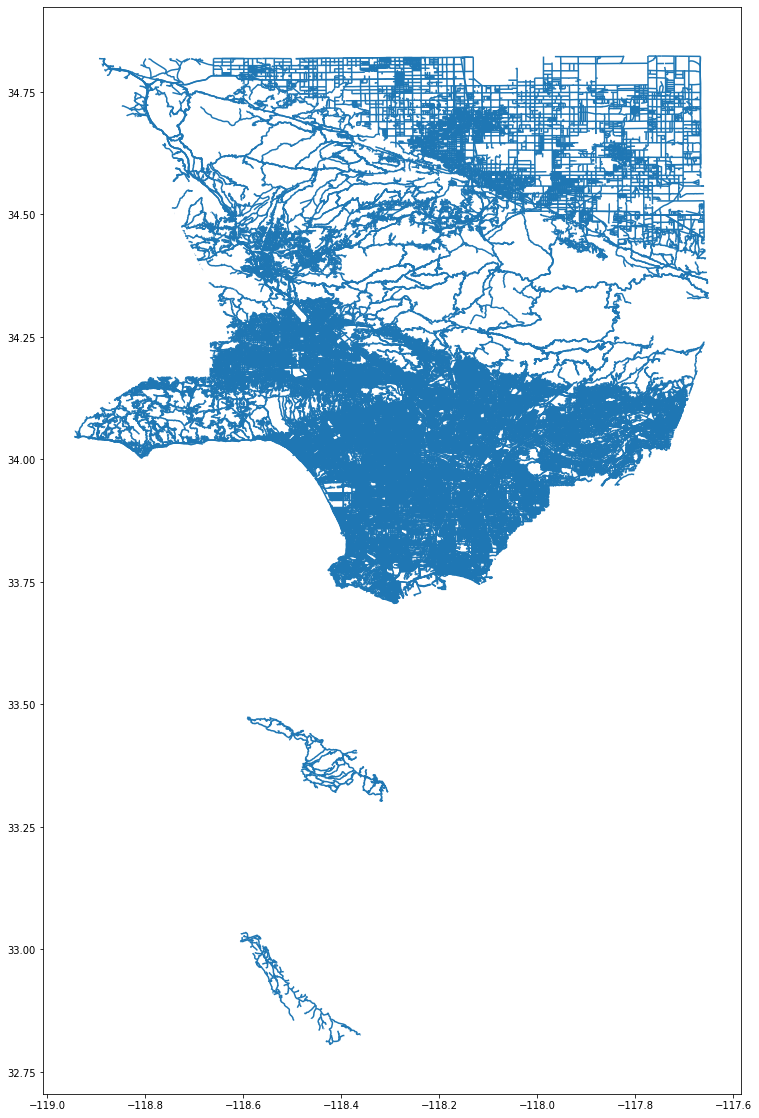

In [19]:
fig, ax = plt.subplots(figsize = (20,20))
street_map.plot(ax=ax)

In [20]:
df.longitude = df.longitude/1e6
df.latitude = df.latitude/1e6

crs = {'init': 'epsg:4326' }
geometry = [Point(xy) for xy in zip(df['longitude'], df['latitude'])]



In [21]:
geo_df = gpd.GeoDataFrame(df, crs=crs, geometry = geometry)
geo_df.head()

parcelid       id  bathroomcnt  bedroomcnt  buildingqualitytypeid  \
0  10711855  1087254            2           3                    8.0   
1  10711877  1072280            2           4                    8.0   
2  10711888  1340933            2           4                    8.0   
3  10711910  1878109            2           3                    8.0   
4  10711923  2190858            2           4                    8.0   

   calculatedfinishedsquarefeet  heatingorsystemtypeid   latitude   longitude  \
0                        2107.0                    2.0  34.222559 -118.617387   
1                        1882.0                    2.0  34.220261 -118.616409   
2                        1882.0                    2.0  34.222491 -118.616854   
3                        1477.0                    2.0  34.221864 -118.615739   
4                        1918.0                    2.0  34.220619 -118.615253   

   lotsizesquarefeet  propertylandusetypeid  rawcensustractandblock  \
0             9158.0                    261            6.037113e+07   
1             9035.0                    261            6.037113e+07   
2             9800.0                    261            6.037113e+07   
3            11285.0                    261            6.037113e+07   
4            11239.0                    261            6.037113e+07   

   regionidcounty  regionidzip  yearbuilt  structuretaxvaluedollarcnt  \
0            3101      96339.0     1972.0                    249655.0   
1            3101      96339.0     1972.0                    253000.0   
2            3101      96339.0     1972.0                    257591.0   
3            3101      96339.0     1960.0                     57968.0   
4            3101      96339.0     1960.0                    167869.0   

   taxvaluedollarcnt  assessmentyear  landtaxvaluedollarcnt  taxamount  \
0             624139            2016                 374484    7659.36   
1             660000            2016                 407000    8123.91   
2             542923            2016                 285332    6673.24   
3              78031            2016                  20063    1116.46   
4             415459            2016                 247590    5239.85   

   logerror   taxrate   age  structure_dollar_per_sqft  land_dollar_per_sqft  \
0 -0.007357  0.012272  45.0                 118.488372             40.891461   
1  0.021066  0.012309  45.0                 134.431456             45.047039   
2  0.077174  0.012291  45.0                 136.870882             29.115510   
3 -0.041238  0.014308  57.0                  39.247123              1.777847   
4 -0.009496  0.012612  57.0                  87.522941             22.029540   

  box_id    region                     geometry  
0     10  North_LA  POINT (-118.61739 34.22256)  
1     10  North_LA  POINT (-118.61641 34.22026)  
2     10  North_LA  POINT (-118.61685 34.22249)  
3     10  North_LA  POINT (-118.61574 34.22186)  
4     10  North_LA  POINT (-118.61525 34.22062)

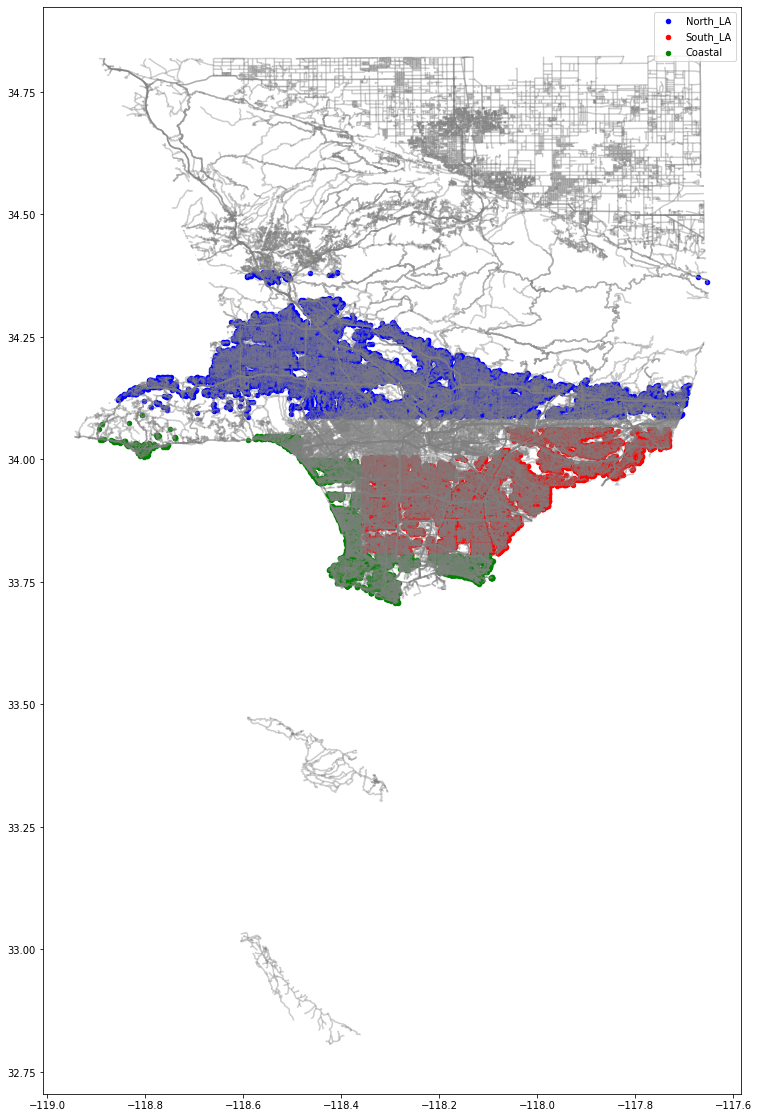

In [22]:
fig, ax = plt.subplots(figsize = (20,20))
street_map.plot(ax=ax, alpha = 0.4, color = 'grey')
geo_df[geo_df.region == 'North_LA'].plot(ax=ax, markersize = 20, color = 'blue', marker = 'o', label= 'North_LA')
geo_df[geo_df.region == 'South_LA'].plot(ax=ax, markersize = 20, color = 'red', marker = 'o', label= 'South_LA')
geo_df[geo_df.region == 'Coastal'].plot(ax=ax, markersize = 20, color = 'green', marker = 'o', label= 'Coastal')
# geo_df[geo_df.region == 'Everywhere_Else'].plot(ax=ax, markersize = 20, color = 'yellow', marker = 'o', label= 'Everywhere_Else')
plt.legend()

## Dropping some more columns for redundancy purposes

In [23]:
df = df.drop(columns = ['buildingqualitytypeid','assessmentyear','heatingorsystemtypeid', 'propertylandusetypeid', 'rawcensustractandblock', 'regionidzip', 'yearbuilt', 'structuretaxvaluedollarcnt', 'landtaxvaluedollarcnt' ])

## Split

In [24]:
train, test = train_test_split(df, test_size=.30, random_state = 123)

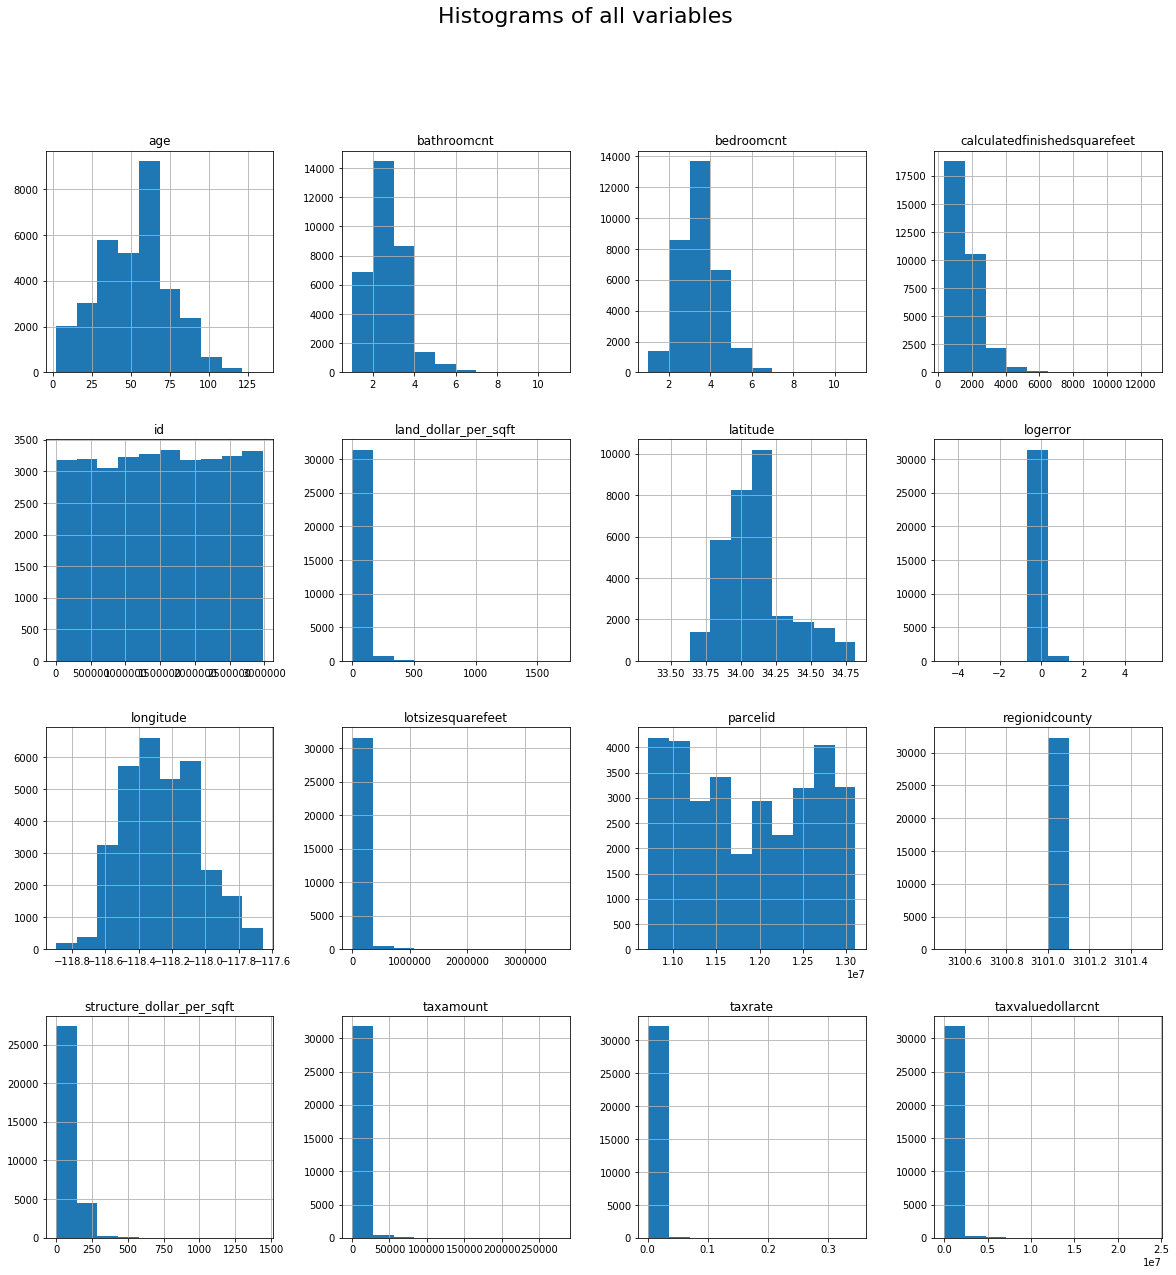

In [25]:
train.hist(figsize=(20, 20), bins=10, log=False)
plt.suptitle('Histograms of all variables', fontsize = 22)
plt.show()

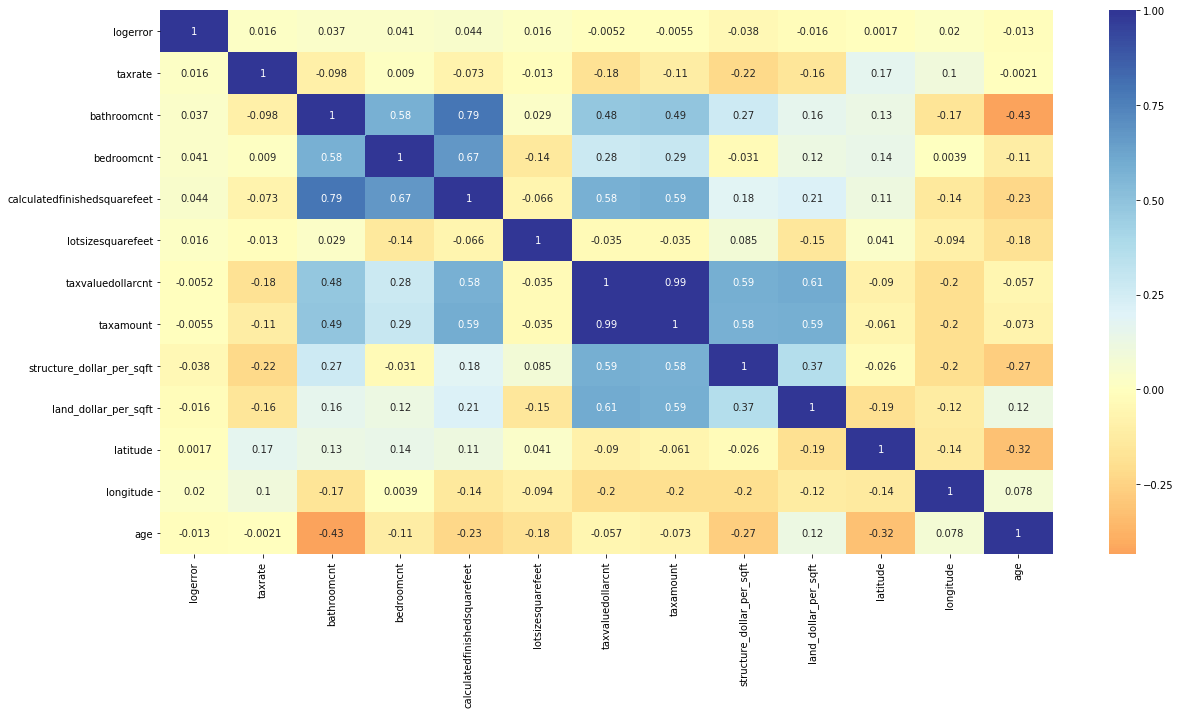

In [26]:
corr1 = train[['logerror', 'taxrate', 'box_id',
       'region', 'geometry', 'bathroomcnt', 'bedroomcnt',
       'calculatedfinishedsquarefeet', 'lotsizesquarefeet',
       'taxvaluedollarcnt', 'taxamount', 'structure_dollar_per_sqft',
       'land_dollar_per_sqft', 'latitude', 'longitude', 'age']]
plt.figure(figsize=(20,10))
sns.heatmap(corr1.corr(), cmap='RdYlBu', annot=True, center=0)
plt.show()

## Scale and What Not. Uniform when distance isn't too much of a concern, MinMax for when it is.

In [27]:
def scale_uniform(train, test, column_list):
    scaler = QuantileTransformer(output_distribution='uniform', random_state=123)
    train_scaled = pd.DataFrame(scaler.fit_transform(train[column_list]), 
                                columns = column_list, 
                                index = train.index)
    train.drop(columns=column_list, inplace=True)
    train = train.join(train_scaled)
    
    test_scaled = pd.DataFrame(scaler.transform(test[column_list]), 
                                columns = column_list, 
                                index = test.index)
    test.drop(columns=column_list, inplace=True)
    test = test.join(test_scaled)
    
    return train, test, scaler

def scale_minmax(train, test, column_list):
    scaler = MinMaxScaler(feature_range=(0,1))
    train_scaled = pd.DataFrame(scaler.fit_transform(train[column_list]), 
                                columns = column_list, 
                                index = train.index)
    train.drop(columns=column_list, inplace=True)
    train = train.join(train_scaled)
    
    test_scaled = pd.DataFrame(scaler.transform(test[column_list]), 
                                columns = column_list, 
                                index = test.index)
    test.drop(columns=column_list, inplace=True)
    test = test.join(test_scaled)
    
    return train, test, scaler

In [28]:
train.columns

Index(['parcelid', 'id', 'bathroomcnt', 'bedroomcnt',
       'calculatedfinishedsquarefeet', 'latitude', 'longitude',
       'lotsizesquarefeet', 'regionidcounty', 'taxvaluedollarcnt', 'taxamount',
       'logerror', 'taxrate', 'age', 'structure_dollar_per_sqft',
       'land_dollar_per_sqft', 'box_id', 'region', 'geometry'],
      dtype='object')

In [29]:
column_list1 = ['bathroomcnt', 'bedroomcnt',
       'calculatedfinishedsquarefeet','lotsizesquarefeet','taxvaluedollarcnt','taxamount','structure_dollar_per_sqft', 'land_dollar_per_sqft']
train, test, scaler_uniform = scale_uniform(train, test, column_list1)

column_list2 = ['latitude','longitude','age']
train, test, scaler_minmax = scale_minmax(train, test, column_list2)

## 2D representation of Regions

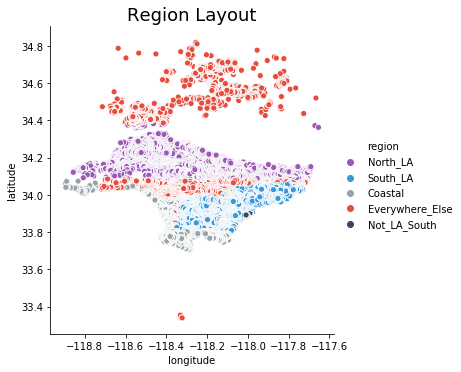

In [30]:
flatui = ["#9b59b6", "#3498db", "#95a5a6", "#e74c3c", "#34495e", "#2ecc71"]
sns.relplot(data=df, x='longitude', y='latitude', hue='region', palette = sns.color_palette(flatui, n_colors=5))
plt.title('Region Layout', fontsize = 18)
plt.show()

## Let's cluster again...

In [31]:
train.columns

Index(['parcelid', 'id', 'regionidcounty', 'logerror', 'taxrate', 'box_id',
       'region', 'geometry', 'bathroomcnt', 'bedroomcnt',
       'calculatedfinishedsquarefeet', 'lotsizesquarefeet',
       'taxvaluedollarcnt', 'taxamount', 'structure_dollar_per_sqft',
       'land_dollar_per_sqft', 'latitude', 'longitude', 'age'],
      dtype='object')

In [32]:
# Put your columns into a list.... this column focuses on location
cluster1_cols = ['latitude','longitude','structure_dollar_per_sqft', 'calculatedfinishedsquarefeet', 'taxvaluedollarcnt']


In [33]:
def select_k(cluster_df, ks):
    sse = []
    for k in ks:
        kmeans = KMeans(n_clusters=k, n_init=1, max_iter=100, random_state=123)
        kmeans.fit(cluster_df)

        # inertia: Sum of squared distances of samples to their closest cluster center.
        sse.append(kmeans.inertia_)

    # print(pd.DataFrame(dict(k=ks, sse=sse)))

    p = plt.plot(ks, sse, 'bx-')
    p = plt.xlabel('k')
    p = plt.ylabel('SSE')
    p = plt.title('The Elbow Method to find the optimal k')

    compare_df = pd.DataFrame(dict(k=ks, sse=sse)).assign(change_in_sse=lambda df: df.sse.diff())
    return compare_df, p

(   k          sse  change_in_sse
 0  1  9824.227920            NaN
 1  2  6345.387553   -3478.840367
 2  3  4900.181795   -1445.205758
 3  4  4187.292699    -712.889096
 4  5  3940.667113    -246.625585
 5  6  3487.316491    -453.350622
 6  7  3241.307327    -246.009164
 7  8  2987.232352    -254.074975
 8  9  2775.879752    -211.352600,
 Text(0.5, 1.0, 'The Elbow Method to find the optimal k'))

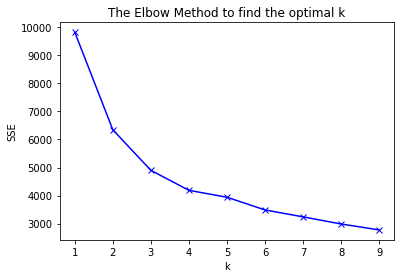

In [34]:
# Look at the SSE for each K to see where the best cutoff lies....
select_k(cluster_df = train[cluster1_cols], ks = range(1,10))

__Could be 5 or 6 K. Let's see if we can determine which is best.__

In [35]:
# Looking at the difference between to cluster groups...

def compare_clusters(cluster_df, x_column, y_column, z_column, k1, k2):
    estimators = [(str(k1)+' Clusters', KMeans(n_clusters=k1, n_init=1, max_iter=100, random_state=123)),
                  (str(k2)+' Clusters', KMeans(n_clusters=k2, n_init=1, max_iter=100, random_state=123))]
    
    fig, axs = plt.subplots(1, 2, figsize=(14, 6), subplot_kw={'projection': '3d'})
    
    for ax, (title, kmeans) in zip(axs, estimators):
        # fit the kmeans object
        kmeans.fit(cluster_df)
        
        labels = kmeans.labels_
        
        ax.scatter(cluster_df[x_column], 
                   cluster_df[y_column],
                   cluster_df[z_column],
                   c=labels.astype(np.float), edgecolor='k')
        ax.set(xticklabels=[], yticklabels=[], zticklabels=[])
        ax.set(xlabel=x_column, ylabel=y_column, zlabel=z_column)
        ax.set(title=title)
    
    plt.show()

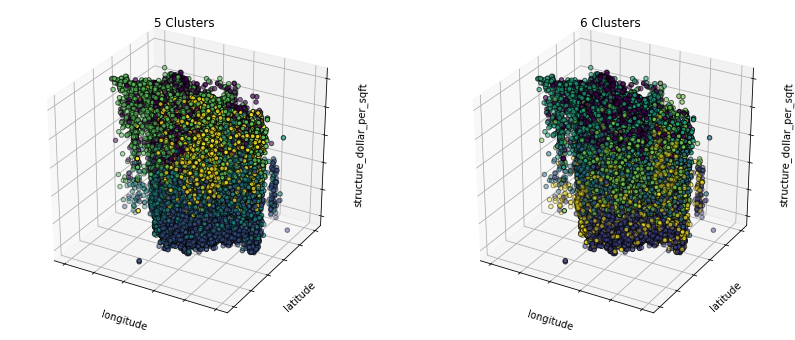

In [36]:
compare_clusters(cluster_df=train[cluster1_cols],
                x_column='longitude', y_column='latitude', z_column='structure_dollar_per_sqft',
                k1=5, k2=6)

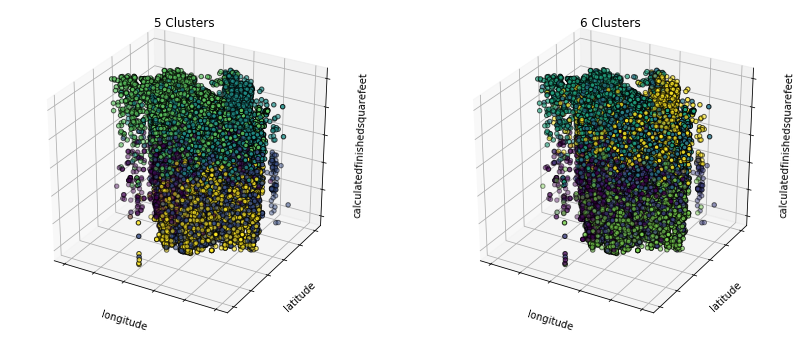

In [37]:
compare_clusters(cluster_df=train[cluster1_cols],
                x_column='longitude', y_column='latitude', z_column='calculatedfinishedsquarefeet',
                k1=5, k2=6)

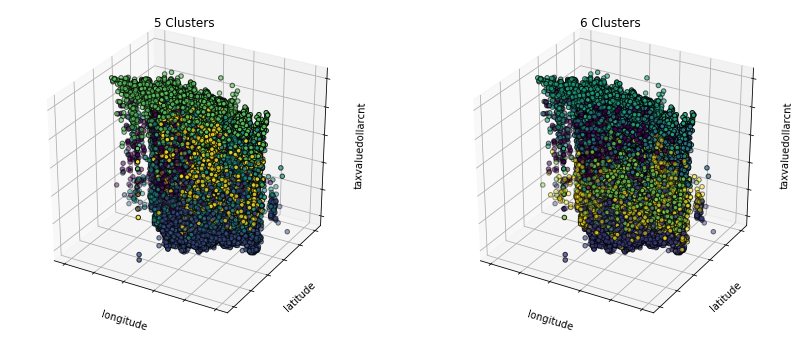

In [38]:
compare_clusters(cluster_df=train[cluster1_cols],
                x_column='longitude', y_column='latitude', z_column='taxvaluedollarcnt',
                k1=5, k2=6)

__6 Clusters seems to be a little more clear.__

In [39]:
def create_k_clusters(train, test, cluster_feature_id, cluster_cols, k):
    kmeans = KMeans(n_clusters=k, n_init=1, max_iter=100, random_state=123)
    kmeans.fit(train[cluster_cols])
    cluster_feature = 'cluster'+str(cluster_feature_id)+'_id'
    train[cluster_feature] = kmeans.predict(train[cluster_cols])
    test[cluster_feature] = kmeans.predict(test[cluster_cols])
    return train, test, kmeans

In [40]:
train, test, kmeans1 = create_k_clusters(train, test, cluster_feature_id = 1, cluster_cols = cluster1_cols, k=6)

In [41]:
# Changing the name in case I want to make more clusters later...

train.rename(index=str, columns={'cluster1_id': 'cluster_loc'}, inplace=True)
test.rename(index=str, columns={'cluster1_id': 'cluster_loc'}, inplace=True)

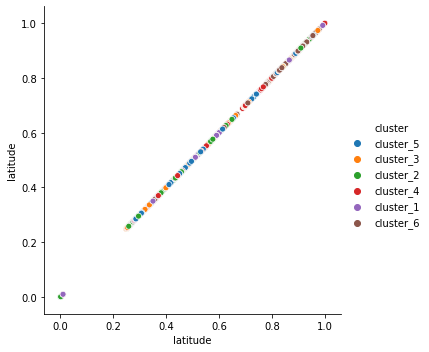

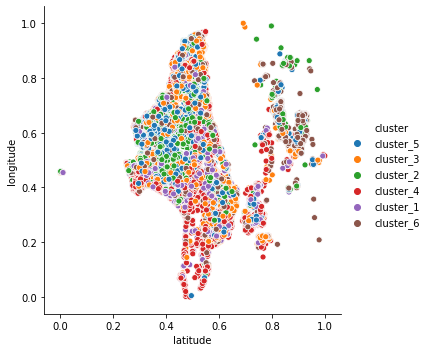

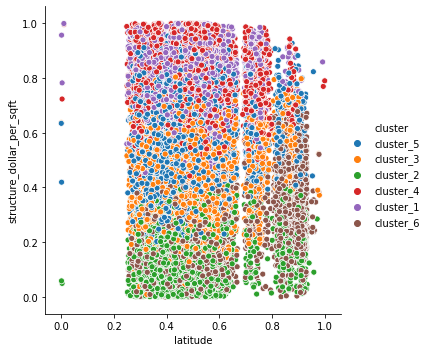

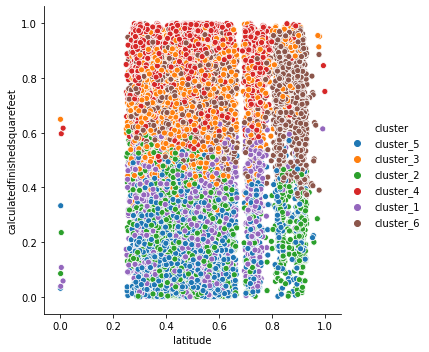

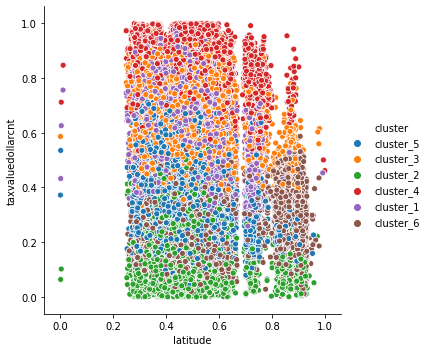

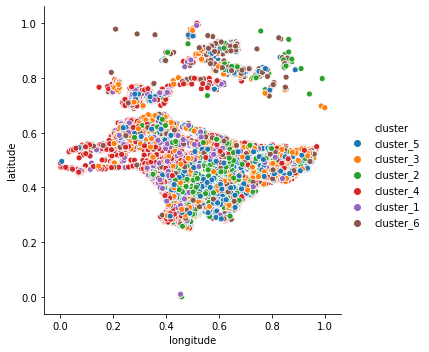

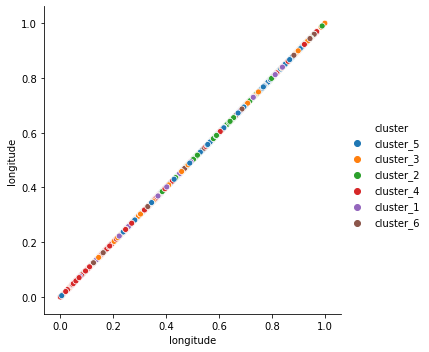

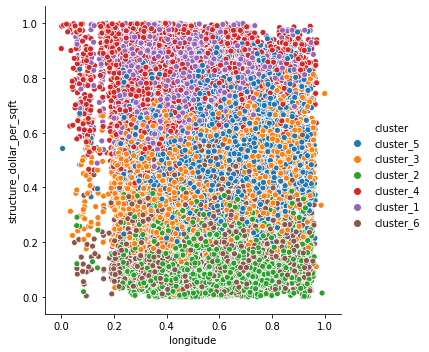

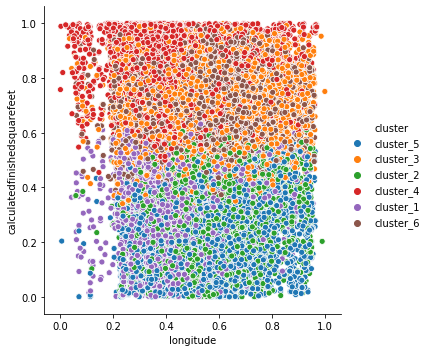

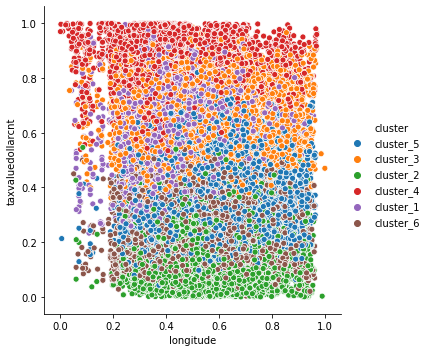

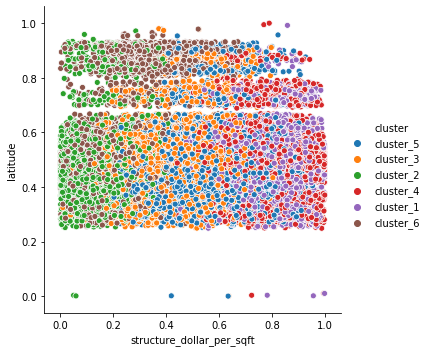

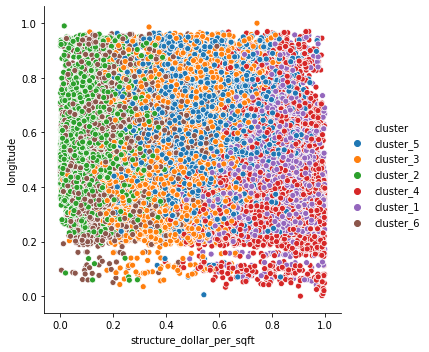

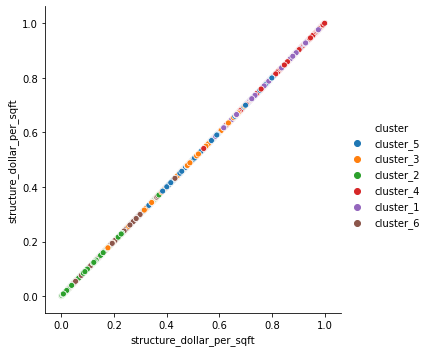

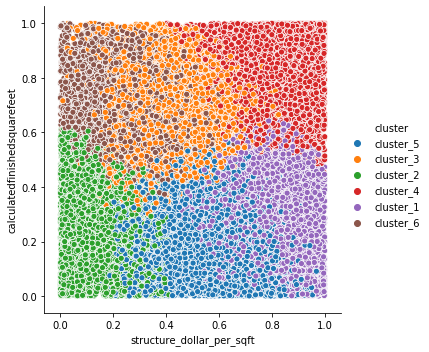

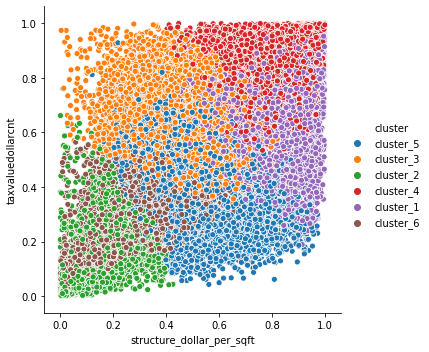

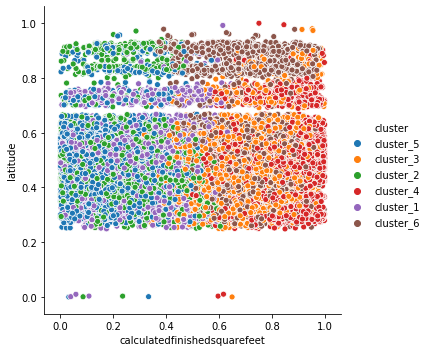

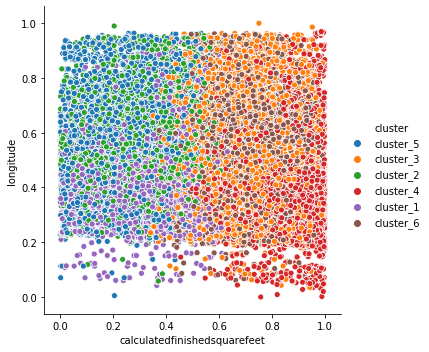

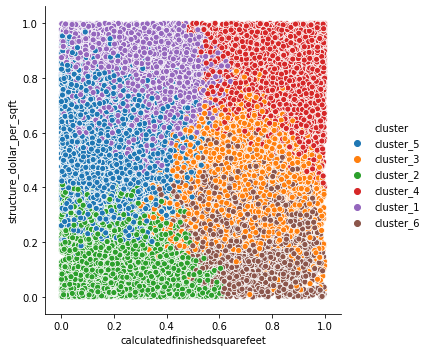

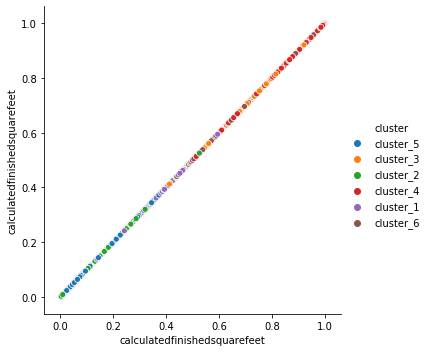

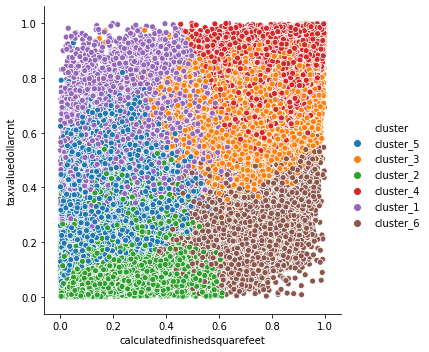

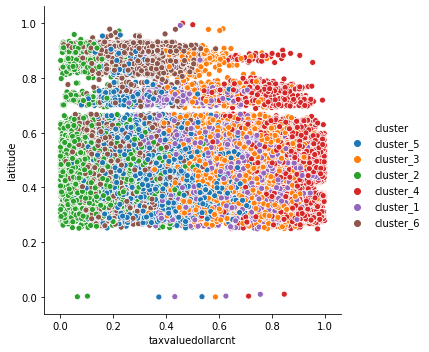

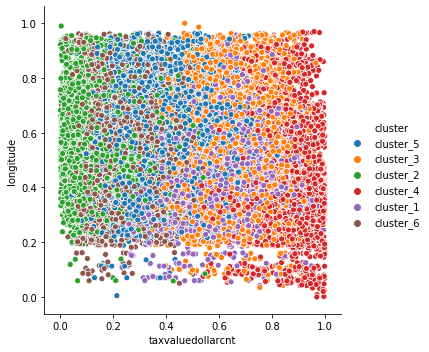

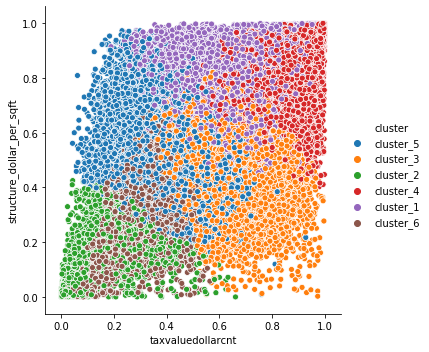

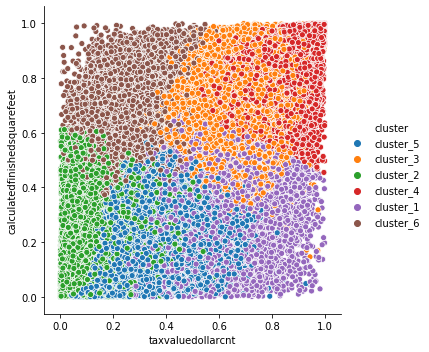

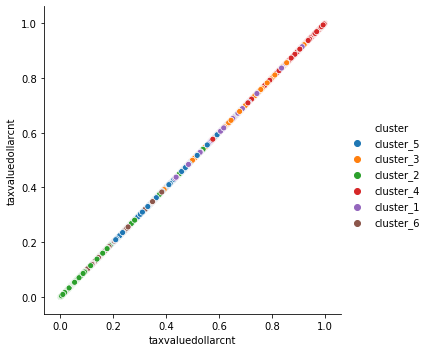

In [42]:
# Creating a column to store the kmean labels, also graphs

train['cluster'] = kmeans1.labels_
train.cluster = 'cluster_' + (train.cluster + 1).astype('str')
for i in range(0,len(cluster1_cols)):
    for j in range(0, len(cluster1_cols)):
        sns.relplot(data=train, x=cluster1_cols[i], y=cluster1_cols[j], hue='cluster')

In [43]:
less_significant_clusters = []

for i in range(0,len((train.cluster_loc)+1)):
    stat, pval = stats.ttest_ind(
        train[train.cluster_loc == i].logerror.dropna(),
        train[train.cluster_loc != i].logerror.dropna())
    if pval > .05:
        less_significant_clusters = less_significant_clusters + [i]
        


## Identifying Weak Clusters

In [44]:
less_significant_clusters

[2, 3, 4]

In [45]:
# If a row is located in one of those clusters above, it's replaced with a -1 instead of it's previous cluster loc.

train.cluster_loc = train.cluster_loc.replace(less_significant_clusters, -1)
test.cluster_loc = test.cluster_loc.replace(less_significant_clusters, -1)

In [46]:
train.columns

Index(['parcelid', 'id', 'regionidcounty', 'logerror', 'taxrate', 'box_id',
       'region', 'geometry', 'bathroomcnt', 'bedroomcnt',
       'calculatedfinishedsquarefeet', 'lotsizesquarefeet',
       'taxvaluedollarcnt', 'taxamount', 'structure_dollar_per_sqft',
       'land_dollar_per_sqft', 'latitude', 'longitude', 'age', 'cluster_loc',
       'cluster'],
      dtype='object')

In [65]:
# Segregating by cluster columns or not

cols_to_remove = ['parcelid', 'id', 'regionidcounty', 'box_id' ]
non_cluster_features = ['taxvaluedollarcnt', 'lotsizesquarefeet', 'parcelid', 'id','taxamount', 'calculatedfinishedsquarefeet',
                        'land_dollar_per_sqft','taxvaluedollarcnt','structure_dollar_per_sqft','bathroomcnt', 'bedroomcnt', 'latitude', 'longitude', 'age',]
train_no_clusters = train[non_cluster_features+['region','logerror']]
test_no_clusters = test[non_cluster_features+['region','logerror']]




In [66]:
cols_to_remove = cols_to_remove + non_cluster_features
train_clusters = train.drop(columns=cols_to_remove +['cluster'])
test_clusters = test.drop(columns=cols_to_remove)

## Let's  Encode Again!!

In [67]:
def encode(train, test, col_name):
  
    encoded_values = sorted(list(train[col_name].unique()))
    columns = [col_name + '_' + str(val) for val in encoded_values]

    # Integer Encoding
    int_encoder = LabelEncoder()
    train.encoded = int_encoder.fit_transform(train[col_name])
    test.encoded = int_encoder.transform(test[col_name])

    # create 2D np arrays of the encoded variable (in train and test)
    train_array = np.array(train.encoded).reshape(len(train.encoded),1)
    test_array = np.array(test.encoded).reshape(len(test.encoded),1)
    
    # One Hot Encoding
    ohe = OneHotEncoder(sparse=False, categories='auto')
    train_ohe = ohe.fit_transform(train_array)
    test_ohe = ohe.transform(test_array)

    # Turn the array of new values into a data frame with columns names being the values
    # and index matching that of train/test
    # then merge the new dataframe with the existing train/test dataframe
    train_encoded = pd.DataFrame(data=train_ohe,
                            columns=columns, index=train.index)
    train = train.join(train_encoded)

    test_encoded = pd.DataFrame(data=test_ohe,
                               columns=columns, index=test.index)
    test = test.join(test_encoded)

    return train, test, int_encoder, ohe

def one_hot_encode(train, test, col_name):
  
    encoded_values = sorted(list(train[col_name].unique()))
    columns = [col_name + '_' + str(val) for val in encoded_values]

    # create 2D np arrays of the encoded variable (in train and test)
    train_array = np.array(train[col_name]).reshape(len(train[col_name]),1)
    test_array = np.array(test[col_name]).reshape(len(test[col_name]),1)
    
    # One Hot Encoding
    ohe = OneHotEncoder(sparse=False, categories='auto')
    train_ohe = ohe.fit_transform(train_array)
    test_ohe = ohe.transform(test_array)

    # Turn the array of new values into a data frame with columns names being the values
    # and index matching that of train/test
    # then merge the new dataframe with the existing train/test dataframe
    train_encoded = pd.DataFrame(data=train_ohe,
                            columns=columns, index=train.index)
    train = train.join(train_encoded)

    test_encoded = pd.DataFrame(data=test_ohe,
                               columns=columns, index=test.index)
    test = test.join(test_encoded)

    return train, test, ohe

In [68]:
train_clusters, test_clusters, ohe_loc = one_hot_encode(train_clusters, test_clusters, 'cluster_loc')

## Let's separate by these completely random areas that I made, save for the "Everywhere_else", which is a mash up of misplotting.

__Cluster First__

In [69]:
train_coast_c = train_clusters[train_clusters.region =='Coastal']
test_coast_c = test_clusters[test_clusters.region =='Coastal']

train_NLA_c = train_clusters[train_clusters.region =='North_LA']
test_NLA_c = test_clusters[test_clusters.region =='North_LA']

train_SLA_c = train_clusters[train_clusters.region =='South_LA']
test_SLA_c = test_clusters[test_clusters.region =='South_LA']

In [70]:
train_coast_nc = train_no_clusters[train_no_clusters.region =='Coastal']
test_coast_nc = test_no_clusters[test_no_clusters.region =='Coastal']

train_NLA_nc = train_no_clusters[train_no_clusters.region =='North_LA']
test_NLA_nc = test_no_clusters[test_no_clusters.region =='North_LA']

train_SLA_nc = train_no_clusters[train_no_clusters.region == 'South_LA']
test_SLA_nc = test_no_clusters[test_no_clusters.region == 'South_LA']

## Dropping columns

In [71]:
train_coast_c.columns

Index(['logerror', 'taxrate', 'region', 'geometry', 'cluster_loc',
       'cluster_loc_-1', 'cluster_loc_0', 'cluster_loc_1', 'cluster_loc_5'],
      dtype='object')

In [73]:
cols_to_drop = ['cluster_loc', 'taxrate', 'region', 'geometry', 'cluster_loc_-1', 'logerror']

X_train_coast_c = train_coast_c.drop(columns=cols_to_drop)
X_test_coast_c = test_coast_c.drop(columns=cols_to_drop)

X_train_NLA_c = train_NLA_c.drop(columns=cols_to_drop)
X_test_NLA_c = test_NLA_c.drop(columns=cols_to_drop)

X_train_SLA_c = train_SLA_c.drop(columns=cols_to_drop)
X_test_SLA_c = test_SLA_c.drop(columns=cols_to_drop)

In [74]:
train_no_clusters.columns

Index(['taxvaluedollarcnt', 'lotsizesquarefeet', 'parcelid', 'id', 'taxamount',
       'calculatedfinishedsquarefeet', 'land_dollar_per_sqft',
       'taxvaluedollarcnt', 'structure_dollar_per_sqft', 'bathroomcnt',
       'bedroomcnt', 'latitude', 'longitude', 'age', 'region', 'logerror'],
      dtype='object')

In [75]:
cols_to_drop = ['logerror', 'parcelid', 'id', 'region']

X_train_coast_nc = train_coast_nc.drop(columns=cols_to_drop)
X_test_coast_nc = test_coast_nc.drop(columns=cols_to_drop)

X_train_NLA_nc = train_NLA_nc.drop(columns=cols_to_drop)
X_test_NLA_nc = test_NLA_nc.drop(columns=cols_to_drop)

X_train_SLA_nc = train_SLA_nc.drop(columns=cols_to_drop)
X_test_SLA_nc = test_SLA_nc.drop(columns=cols_to_drop)

In [76]:
y_train_coast = train_coast_c[['logerror']]
y_test_coast = test_coast_c[['logerror']]

y_train_NLA = train_NLA_c[['logerror']]
y_test_NLA = test_NLA_c[['logerror']]

y_train_SLA = train_SLA_c[['logerror']]
y_test_SLA = test_SLA_c[['logerror']]

## Modeling 

In [77]:
from sklearn.svm import LinearSVR
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import SGDRegressor, LassoCV
from sklearn.tree import DecisionTreeRegressor

## Coastal Baseline

In [78]:
se = y_train_coast.logerror * y_train_coast.logerror
mse = se.mean()
rmse = mse**1/2
rmse

0.010056935187671957

## Clusters

In [105]:
regr = LinearSVR(random_state=123)
regr.fit(X_train_coast_c, y_train_coast)
y_pred_coast = regr.predict(X_train_coast_c)
print(mean_squared_error(y_train_coast, y_pred_coast)**1/2)

0.00994284993180513


In [80]:
lasso = LassoCV(fit_intercept=False)
lasso.fit(X_train_coast_c, y_train_coast)
y_pred_coast = lasso.predict(X_train_coast_c)
mean_squared_error(y_train_coast, y_pred_coast)**1/2

0.00999597719454792

In [83]:
dt = DecisionTreeRegressor(max_depth = 7, random_state=123)
dt.fit(X_train_coast_c, y_train_coast)
y_pred_coast = dt.predict(X_train_coast_c)
mean_squared_error(y_train_coast, y_pred_coast)**1/2

0.009908394136530503

## Non-clusters

In [106]:
regr = LinearSVR(random_state=123)
regr.fit(X_train_coast_nc, y_train_coast)
y_pred_coast = regr.predict(X_train_coast_nc)
print(mean_squared_error(y_train_coast, y_pred_coast)**1/2)

0.009907063560913287


In [85]:
lasso = LassoCV(fit_intercept=False)
lasso.fit(X_train_coast_nc, y_train_coast)
y_pred_coast = lasso.predict(X_train_coast_nc)
mean_squared_error(y_train_coast, y_pred_coast)**1/2

0.009887542382423993

In [87]:
dt = DecisionTreeRegressor(max_depth = 5, random_state=123)
dt.fit(X_train_coast_nc, y_train_coast)
y_pred_coast = dt.predict(X_train_coast_nc)
mean_squared_error(y_train_coast, y_pred_coast)**1/2

0.00847190675063349

## Takeaways: Coastal properties tend to have less error. A decision tree analysis of non clustered features allow error to be reduced somewhat noticeably.

## North LA Baseline

In [88]:
se = y_train_NLA.logerror * y_train_NLA.logerror
mse = se.mean()
rmse = mse**1/2
rmse

0.011213892901011976

## Clusters

In [107]:
regr = LinearSVR(random_state=123)
regr.fit(X_train_NLA_c, y_train_NLA)
y_pred_NLA = regr.predict(X_train_NLA_c)
print(mean_squared_error(y_train_NLA, y_pred_NLA)**1/2)

0.011104445221381178


In [90]:
lasso = LassoCV(fit_intercept=False)
lasso.fit(X_train_NLA_c, y_train_NLA)
y_pred_NLA = lasso.predict(X_train_NLA_c)
mean_squared_error(y_train_NLA, y_pred_NLA)**1/2

0.01112425494113287

In [94]:
dt = DecisionTreeRegressor(max_depth = 5, random_state=123)
dt.fit(X_train_NLA_c, y_train_NLA)
y_pred_NLA = dt.predict(X_train_NLA_c)
mean_squared_error(y_train_NLA, y_pred_NLA)**1/2

0.01105839661413441

## Takeaways: Might not be that good at clustering

## Non-clusters

In [108]:
regr = LinearSVR(random_state=123)
regr.fit(X_train_NLA_nc, y_train_NLA)
y_pred_NLA = regr.predict(X_train_NLA_nc)
print(mean_squared_error(y_train_NLA, y_pred_NLA)**1/2)

0.01110291590762601


In [93]:
lasso = LassoCV(fit_intercept=False)
lasso.fit(X_train_NLA_nc, y_train_NLA)
y_pred_NLA = lasso.predict(X_train_NLA_nc)
mean_squared_error(y_train_NLA, y_pred_NLA)**1/2

0.011045633924050892

In [96]:
dt = DecisionTreeRegressor(max_depth = 5, random_state=123)
dt.fit(X_train_NLA_nc, y_train_NLA)
y_pred_NLA = dt.predict(X_train_NLA_nc)
mean_squared_error(y_train_NLA, y_pred_NLA)**1/2

0.010292238298874585

## Takeaways: Might not be all that good at clustering or feature selection.

## South LA Baseline

In [97]:
se = y_train_SLA.logerror * y_train_SLA.logerror
mse = se.mean()
rmse = mse**1/2
rmse

0.012129875579399206

## Clusters

In [109]:
regr = LinearSVR(random_state=123)
regr.fit(X_train_SLA_c, y_train_SLA)
y_pred_SLA = regr.predict(X_train_SLA_c)
print(mean_squared_error(y_train_SLA, y_pred_SLA)**1/2)

0.012075017630077772


In [99]:
lasso = LassoCV(fit_intercept=False)
lasso.fit(X_train_SLA_c, y_train_SLA)
y_pred_SLA = lasso.predict(X_train_SLA_c)
mean_squared_error(y_train_SLA, y_pred_SLA)**1/2

0.012058823551463128

In [100]:
dt = DecisionTreeRegressor(max_depth = 5, random_state=123)
dt.fit(X_train_SLA_c, y_train_SLA)
y_pred_SLA = dt.predict(X_train_SLA_c)
mean_squared_error(y_train_SLA, y_pred_SLA)**1/2

0.012001426480412289

## Non clusters

In [110]:
regr = LinearSVR(random_state=123)
regr.fit(X_train_SLA_nc, y_train_SLA)
y_pred_SLA = regr.predict(X_train_SLA_nc)
print(mean_squared_error(y_train_SLA, y_pred_SLA)**1/2)

0.012014209652401207


In [102]:
lasso = LassoCV(fit_intercept=False)
lasso.fit(X_train_SLA_nc, y_train_SLA)
y_pred_SLA = lasso.predict(X_train_SLA_nc)
mean_squared_error(y_train_SLA, y_pred_SLA)**1/2

0.011938660701305545

In [103]:
dt = DecisionTreeRegressor(max_depth = 5, random_state=123)
dt.fit(X_train_SLA_nc, y_train_SLA)
y_pred_SLA = dt.predict(X_train_SLA_nc)
mean_squared_error(y_train_SLA, y_pred_SLA)**1/2

0.01010784705454347

## Takeaways: South LA has the highest of mean squared errors. Cluster based on location and house prices are not good indicators of logerror reduction. More precision is required for location clustering and feature engineering
